<a href="https://colab.research.google.com/github/kchen79427/Capstone_Bruestle_Boudia_Chen/blob/main/EDA/OnTime_EDA_Boudia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
pd.set_option('display.max_rows', 500)

In [ ]:
!pip install pyarrow

In [ ]:
df = pd.read_parquet('data/ontime.snappy.parquet')

In [ ]:
carrier = pd.read_csv('data/CARRIERS.csv',
                      index_col='Code')
carrier.head()

,Description
Code,
02Q,Titan Airways
04Q,Tradewind Aviation
05Q,"Comlux Aviation, AG"
06Q,Master Top Linhas Aereas Ltd.
07Q,Flair Airlines Ltd.


In [ ]:
carrier = carrier['Description'].to_dict()
df[df['Tail_Number']=='86729E']

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,normDelay,FL_Num
102168,2010,1,1,3,7,2010-01-03,9E,20363,9E,86729E,...,,None,None,,None,None,,,0.000000,9E36512010-01-03DSMMSP
102354,2010,1,1,19,2,2010-01-19,9E,20363,9E,86729E,...,,None,None,,None,None,,,0.000000,9E36542010-01-19ICTMSP
102396,2010,1,1,1,5,2010-01-01,9E,20363,9E,86729E,...,,None,None,,None,None,,,0.000000,9E36562010-01-01FSDMSP
102667,2010,1,1,1,5,2010-01-01,9E,20363,9E,86729E,...,,None,None,,None,None,,,0.000000,9E36632010-01-01RAPMSP
102710,2010,1,1,20,3,2010-01-20,9E,20363,9E,86729E,...,,None,None,,None,None,,,0.000000,9E36642010-01-20MBSDTW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13121733,2010,2,6,27,7,2010-06-27,9E,20363,9E,86729E,...,,None,None,,None,None,,,4.127134,9E43232010-06-27AZODTW
13121758,2010,2,6,25,5,2010-06-25,9E,20363,9E,86729E,...,,None,None,,None,None,,,2.397895,9E43232010-06-25DTWJAN
13121800,2010,2,6,20,7,2010-06-20,9E,20363,9E,86729E,...,,None,None,,None,None,,,0.000000,9E43272010-06-20FNTMSP
13122095,2010,2,6,27,7,2010-06-27,9E,20363,9E,86729E,...,,None,None,,None,None,,,0.000000,9E43372010-06-27DTWMBS


In [ ]:
pd.Series(df.Tail_Number.unique()).to_csv('tail_numbers.csv',index=False)

In [ ]:
df.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15900000 entries, 0 to 15899999
Data columns (total 109 columns):
 #    Column                           Non-Null Count     Dtype  
---   ------                           --------------     -----  
 0    Year                             15900000 non-null  int64  
 1    Quarter                          15900000 non-null  int64  
 2    Month                            15900000 non-null  int64  
 3    DayofMonth                       15900000 non-null  int64  
 4    DayOfWeek                        15900000 non-null  int64  
 5    FlightDate                       15900000 non-null  object 
 6    Reporting_Airline                15900000 non-null  object 
 7    DOT_ID_Reporting_Airline         15900000 non-null  int64  
 8    IATA_CODE_Reporting_Airline      15900000 non-null  object 
 9    Tail_Number                      15900000 non-null  object 
 10   Flight_Number_Reporting_Airline  15900000 non-null  int64  
 11   OriginAirportID     

In [ ]:
# Review the years included in the dataset and remove the pandemic years (2020-2022)
yr_lst = list(df.Year.unique())
yr_lst.sort()
yr_lst

[2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022,
 2023]

In [ ]:
df = df[df['Year'].isin([2020,2021,2022]) == False]
df.Year.unique()

array([2010, 2018, 2019, 2011, 2023, 2012, 2013, 2014, 2015, 2016, 2017])

In [ ]:
df = df[df['DepDelay'].isna() == False]

## Target Variable Analysis (Delays)

In [ ]:
df[df['DepDelay'] >= 15]['DepDelay'].describe()

count    2.166747e+06
mean     6.333408e+01
std      7.606075e+01
min      1.500000e+01
25%      2.400000e+01
50%      4.000000e+01
75%      7.500000e+01
max      3.024000e+03
Name: DepDelay, dtype: float64

Just focusing on what's truly considered a delay (>= 15 minutes) there were roughly 2.1 million flights that were delayed.  The mean delay time was 63 min (~1 hour).  The maximum delay was 3024 hours (or a little over 2 days delay).

In [ ]:
dly_grps = df.groupby('DepartureDelayGroups')['DepDelay'].describe()
dly_grps

,count,mean,std,min,25%,50%,75%,max
DepartureDelayGroups,,,,,,,,
-2.0,63755.0,-18.697592,4.171015,-234.0,-20.0,-18.0,-16.0,-16.0
-1.0,7128792.0,-5.010645,2.971328,-15.0,-7.0,-5.0,-3.0,-1.0
0.0,2743973.0,4.484604,4.251924,0.0,1.0,3.0,8.0,14.0
1.0,782584.0,21.037950,4.284154,15.0,17.0,21.0,25.0,29.0
2.0,408187.0,36.325748,4.304873,30.0,33.0,36.0,40.0,44.0
3.0,255938.0,51.505021,4.317179,45.0,48.0,51.0,55.0,59.0
4.0,174589.0,66.541615,4.310365,60.0,63.0,66.0,70.0,74.0
5.0,124562.0,81.601628,4.308363,75.0,78.0,81.0,85.0,89.0
6.0,91759.0,96.622522,4.319139,90.0,93.0,96.0,100.0,104.0


array([[<Axes: title={'center': 'DepartureDelayGroups'}>]], dtype=object)

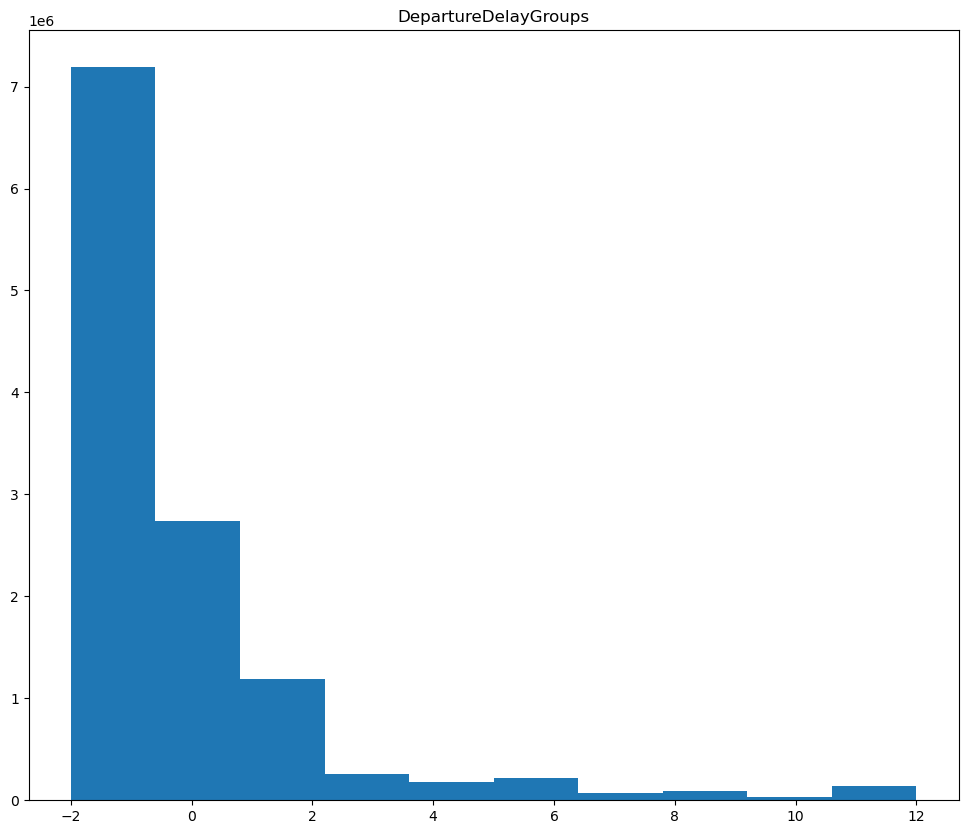

In [ ]:
df.hist(column='DepartureDelayGroups',grid=False,figsize=(12,10))

We see a substantial number of flights actually depart sooner than scheduled.  The group farthest to the left represents anything sooner than 15 minutes from the scheduled departure.  Each bin subsequently decreases in frequency as a general trend.  We do see a bump up in frequency in group 12 but that also contains all outliers (>=180 minutes of delay).

In [ ]:
df['normDelay'] = np.log1p(df['DepDelay'])

/Users/davidboudia/anaconda3/envs/python3_11/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/davidboudia/anaconda3/envs/python3_11/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# many flights didn't have delays and will have a NaN value so we'll plug in with zero
df.normDelay.fillna(0, inplace=True)

<Axes: xlabel='normDelay', ylabel='Count'>

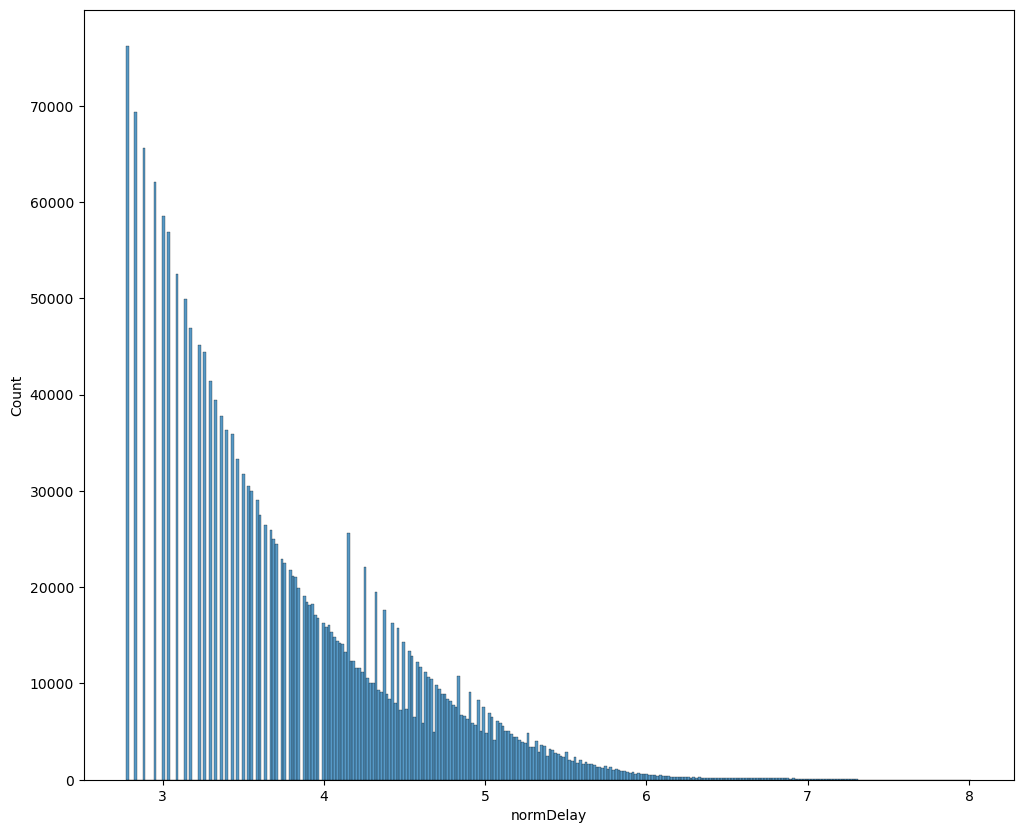

In [ ]:
plt.figure(figsize=(12,10))

sns.histplot(data=df[df['DepDelay'] >=  15],
             x='normDelay')

In [ ]:
recs = len(df)
df.groupby('DepDel15')['Flight_Number_Reporting_Airline'].count()/recs

DepDel15
0.0    0.807847
1.0    0.176158
Name: Flight_Number_Reporting_Airline, dtype: float64

Out of 12.3 million flights, almost 17% had departure delays (15 minutes or longer)

In [ ]:
ardly = df.ArrDel15.value_counts()
ardly / ardly.sum()

0.0    0.809298
1.0    0.190702
Name: ArrDel15, dtype: float64

roughly 18% of the flights that recorded this information have arrival delays

In [ ]:
# Need a unique id for each flight
df['FL_Num'] = df['Reporting_Airline'] + df['Flight_Number_Reporting_Airline'].astype('str') + df['FlightDate'].astype('str') + + df['Origin'] + df['Dest']

In [ ]:
# Confirm derived id accounts for all records (or close to it)
len(df['FL_Num'].unique())

12299997

In [ ]:
# 12.1 million and should be good to use
df.shape

(12300000, 111)

In [ ]:
# Get percentage of delayed flights to total flights by each airline
air_counts = df.groupby(['Reporting_Airline'])['FL_Num'].count()
print(air_counts)
air_perc_delay = pd.DataFrame(df.groupby(['Reporting_Airline', 'DepDel15'])['FL_Num'].count()/ air_counts)
air_perc_delay.reset_index(inplace=True)
air_perc_delay['Airline'] = air_perc_delay['Reporting_Airline'].map(carrier)

Reporting_Airline
9E     494125
AA    3611285
AS     939507
B6    1180268
CO     258559
DL    1524867
EV     537781
F9     122276
FL      66953
G4      23487
HA      61493
MQ     245782
NK     187591
OH      72645
OO     842976
UA     498981
US      84992
VX      50256
WN    1140298
XE     120841
YV     121349
YX     113688
Name: FL_Num, dtype: int64


In [ ]:
# Get the total number of flights each Airline made in the dataset; incorporate full name
total_fly = (air_counts / air_counts.sum()).to_frame()
total_fly['airline'] = total_fly.index.map(carrier)
total_fly.head() # Confirm df looks alright

,FL_Num,airline
Reporting_Airline,,
9E,0.040173,Endeavor Air Inc.
AA,0.293600,American Airlines Inc.
AS,0.076383,Alaska Airlines Inc.
B6,0.095957,JetBlue Airways
CO,0.021021,Continental Air Lines Inc.


In [ ]:
df['Org_Airline'] = df['Reporting_Airline'].map(carrier)

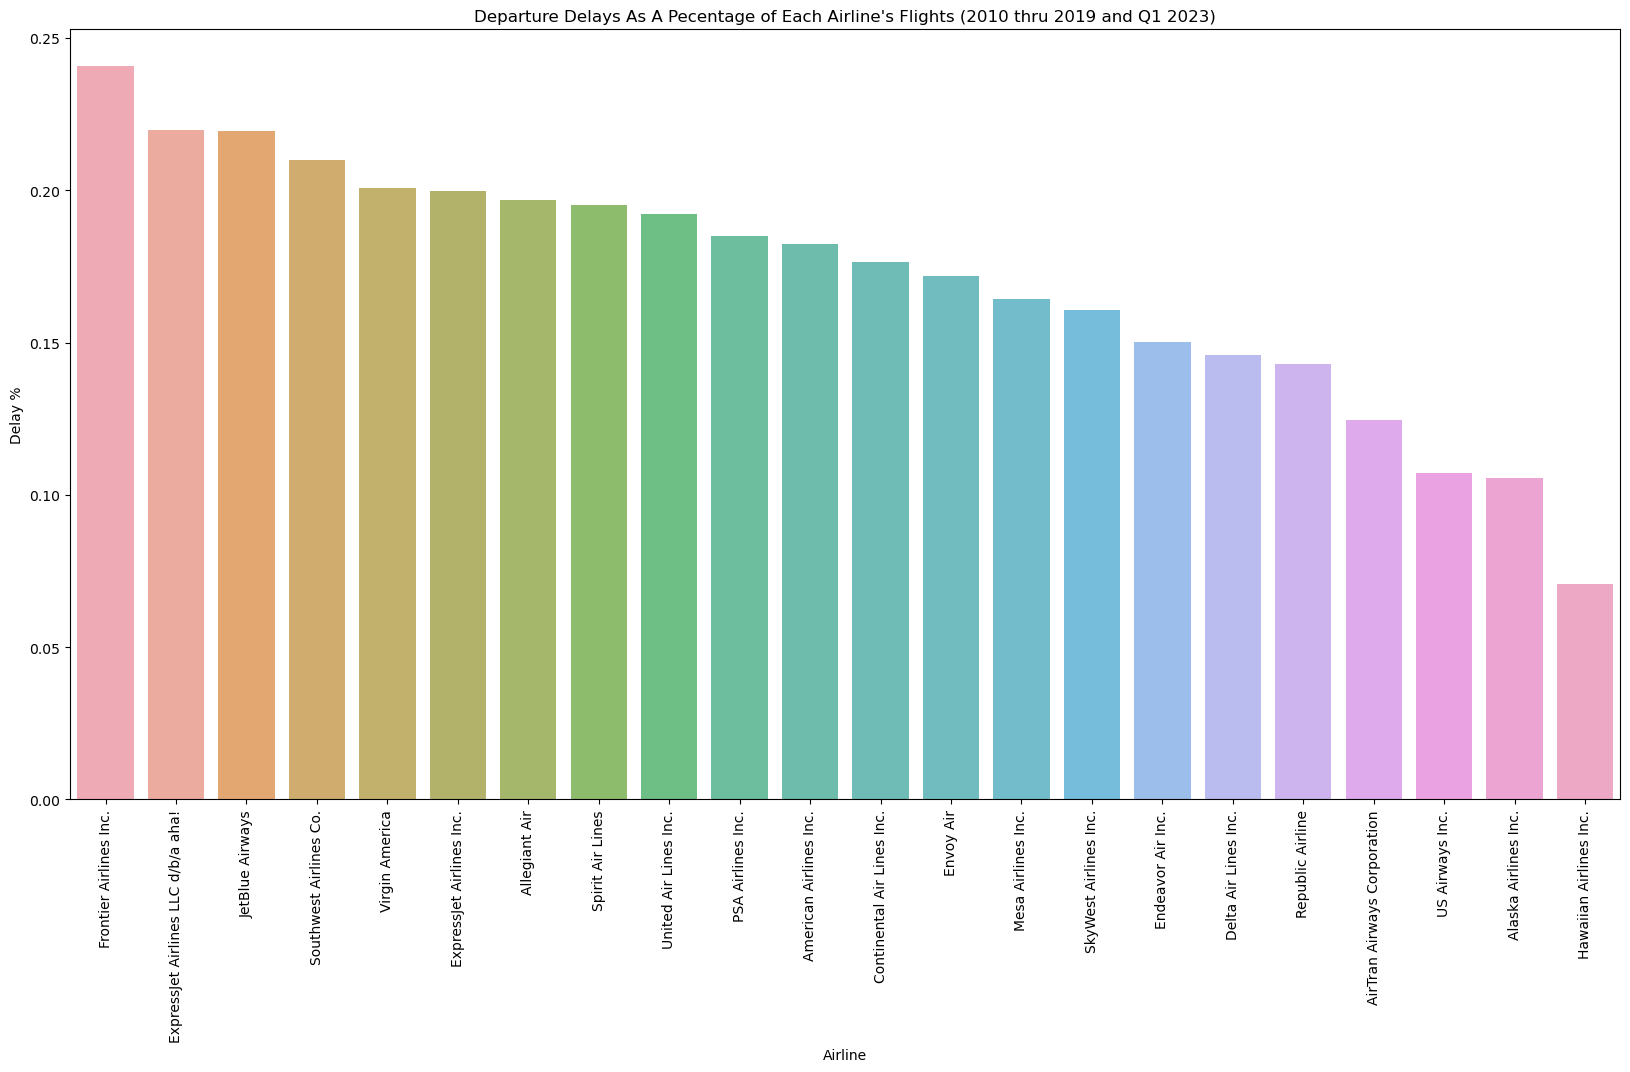

In [ ]:
plt.figure(figsize=(20,10))
data = air_perc_delay[air_perc_delay['DepDel15']==1.0].sort_values('FL_Num', ascending=False)
kwargs = {'alpha':0.8}

dly= sns.barplot(data=data,
            x='Airline',
            y='FL_Num',
            **kwargs)

plt.xticks(rotation = 90);
plt.ylabel('Delay %')
plt.title('Departure Delays As A Pecentage of Each Airline\'s Flights (2010 thru 2019 and Q1 2023)')
dly.set_alpha(.1)


                     FL_Num                             airline
Reporting_Airline                                              
AA                 0.293600              American Airlines Inc.
DL                 0.123973                Delta Air Lines Inc.
B6                 0.095957                     JetBlue Airways
WN                 0.092707              Southwest Airlines Co.
AS                 0.076383                Alaska Airlines Inc.
OO                 0.068535               SkyWest Airlines Inc.
EV                 0.043722  ExpressJet Airlines LLC d/b/a aha!
UA                 0.040568               United Air Lines Inc.
9E                 0.040173                   Endeavor Air Inc.
CO                 0.021021          Continental Air Lines Inc.
MQ                 0.019982                           Envoy Air
NK                 0.015251                    Spirit Air Lines
F9                 0.009941              Frontier Airlines Inc.
YV                 0.009866             

Text(0.5, 1.0, 'Airline Flights As A Percentage of Total Flights (w/Delay Information) in Dataset (2010 thru 2019 and Q1 2023)')

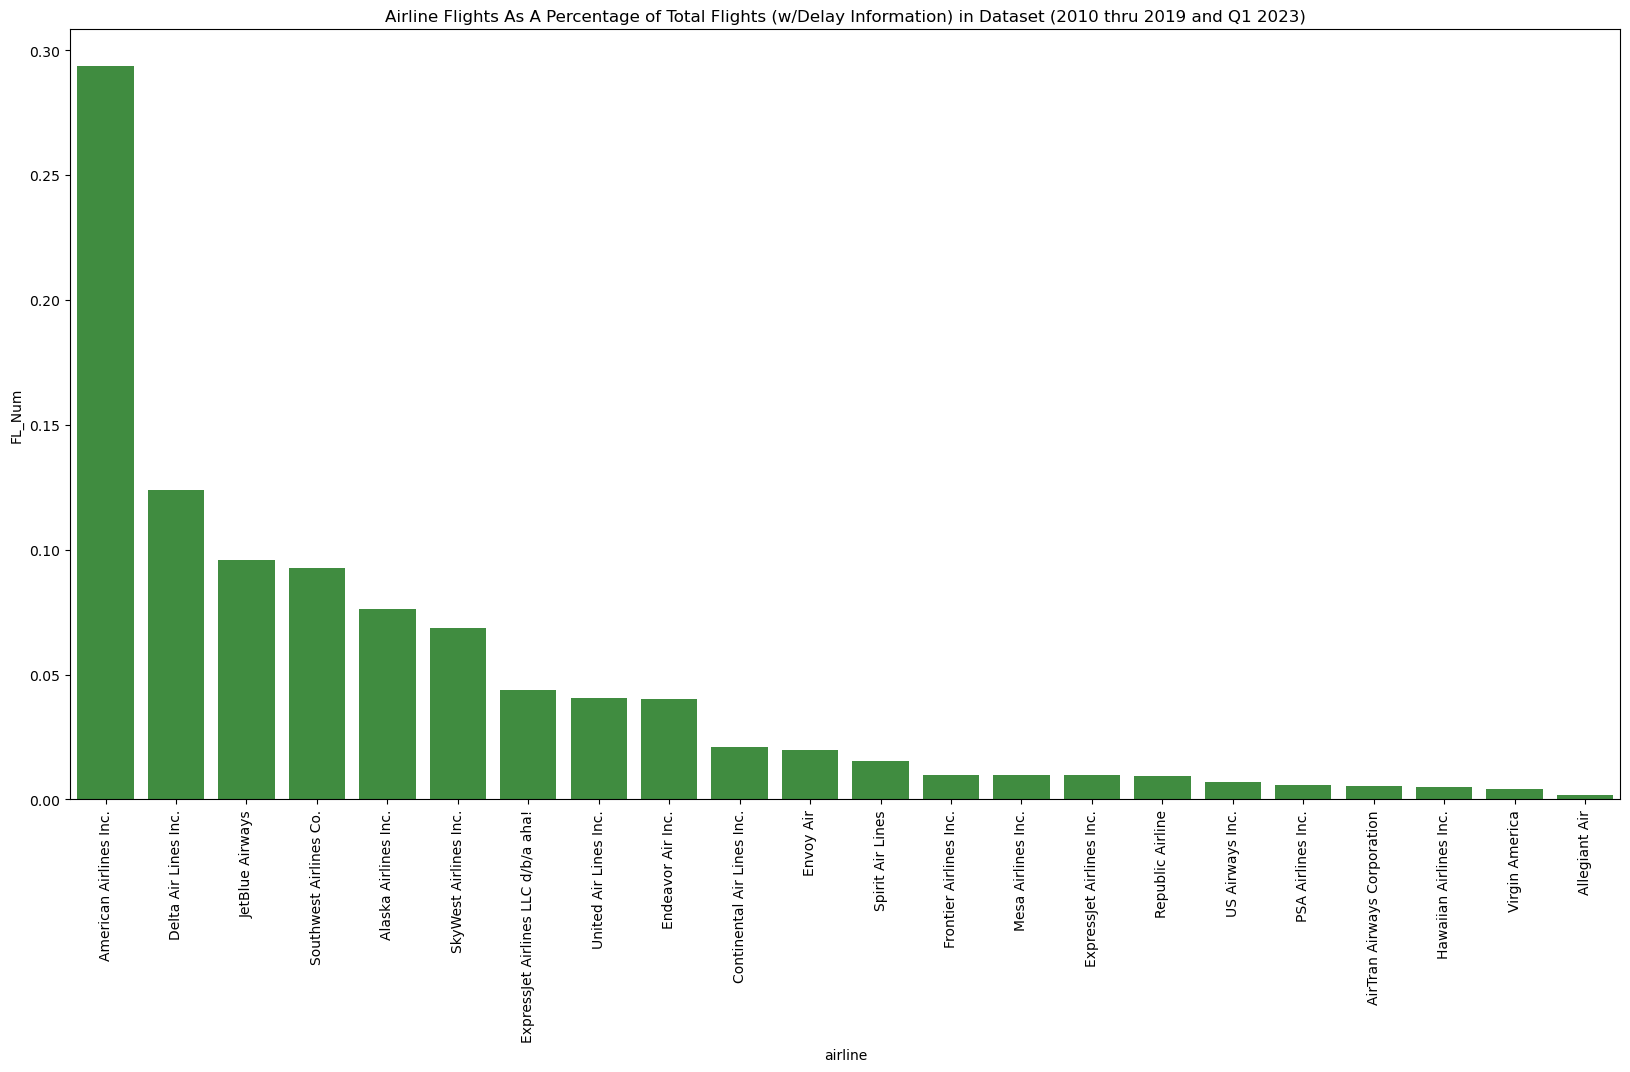

In [ ]:
plt.figure(figsize=(20,10))
total_fly = total_fly.sort_values('FL_Num', ascending=False)
print(total_fly)
mkt = sns.barplot(data=total_fly,
            x='airline',
            y='FL_Num',
            color='g', **kwargs);
plt.xticks(rotation = 90);
plt.title('Airline Flights As A Percentage of Total Flights (w/Delay Information) in Dataset (2010 thru 2019 and Q1 2023)')




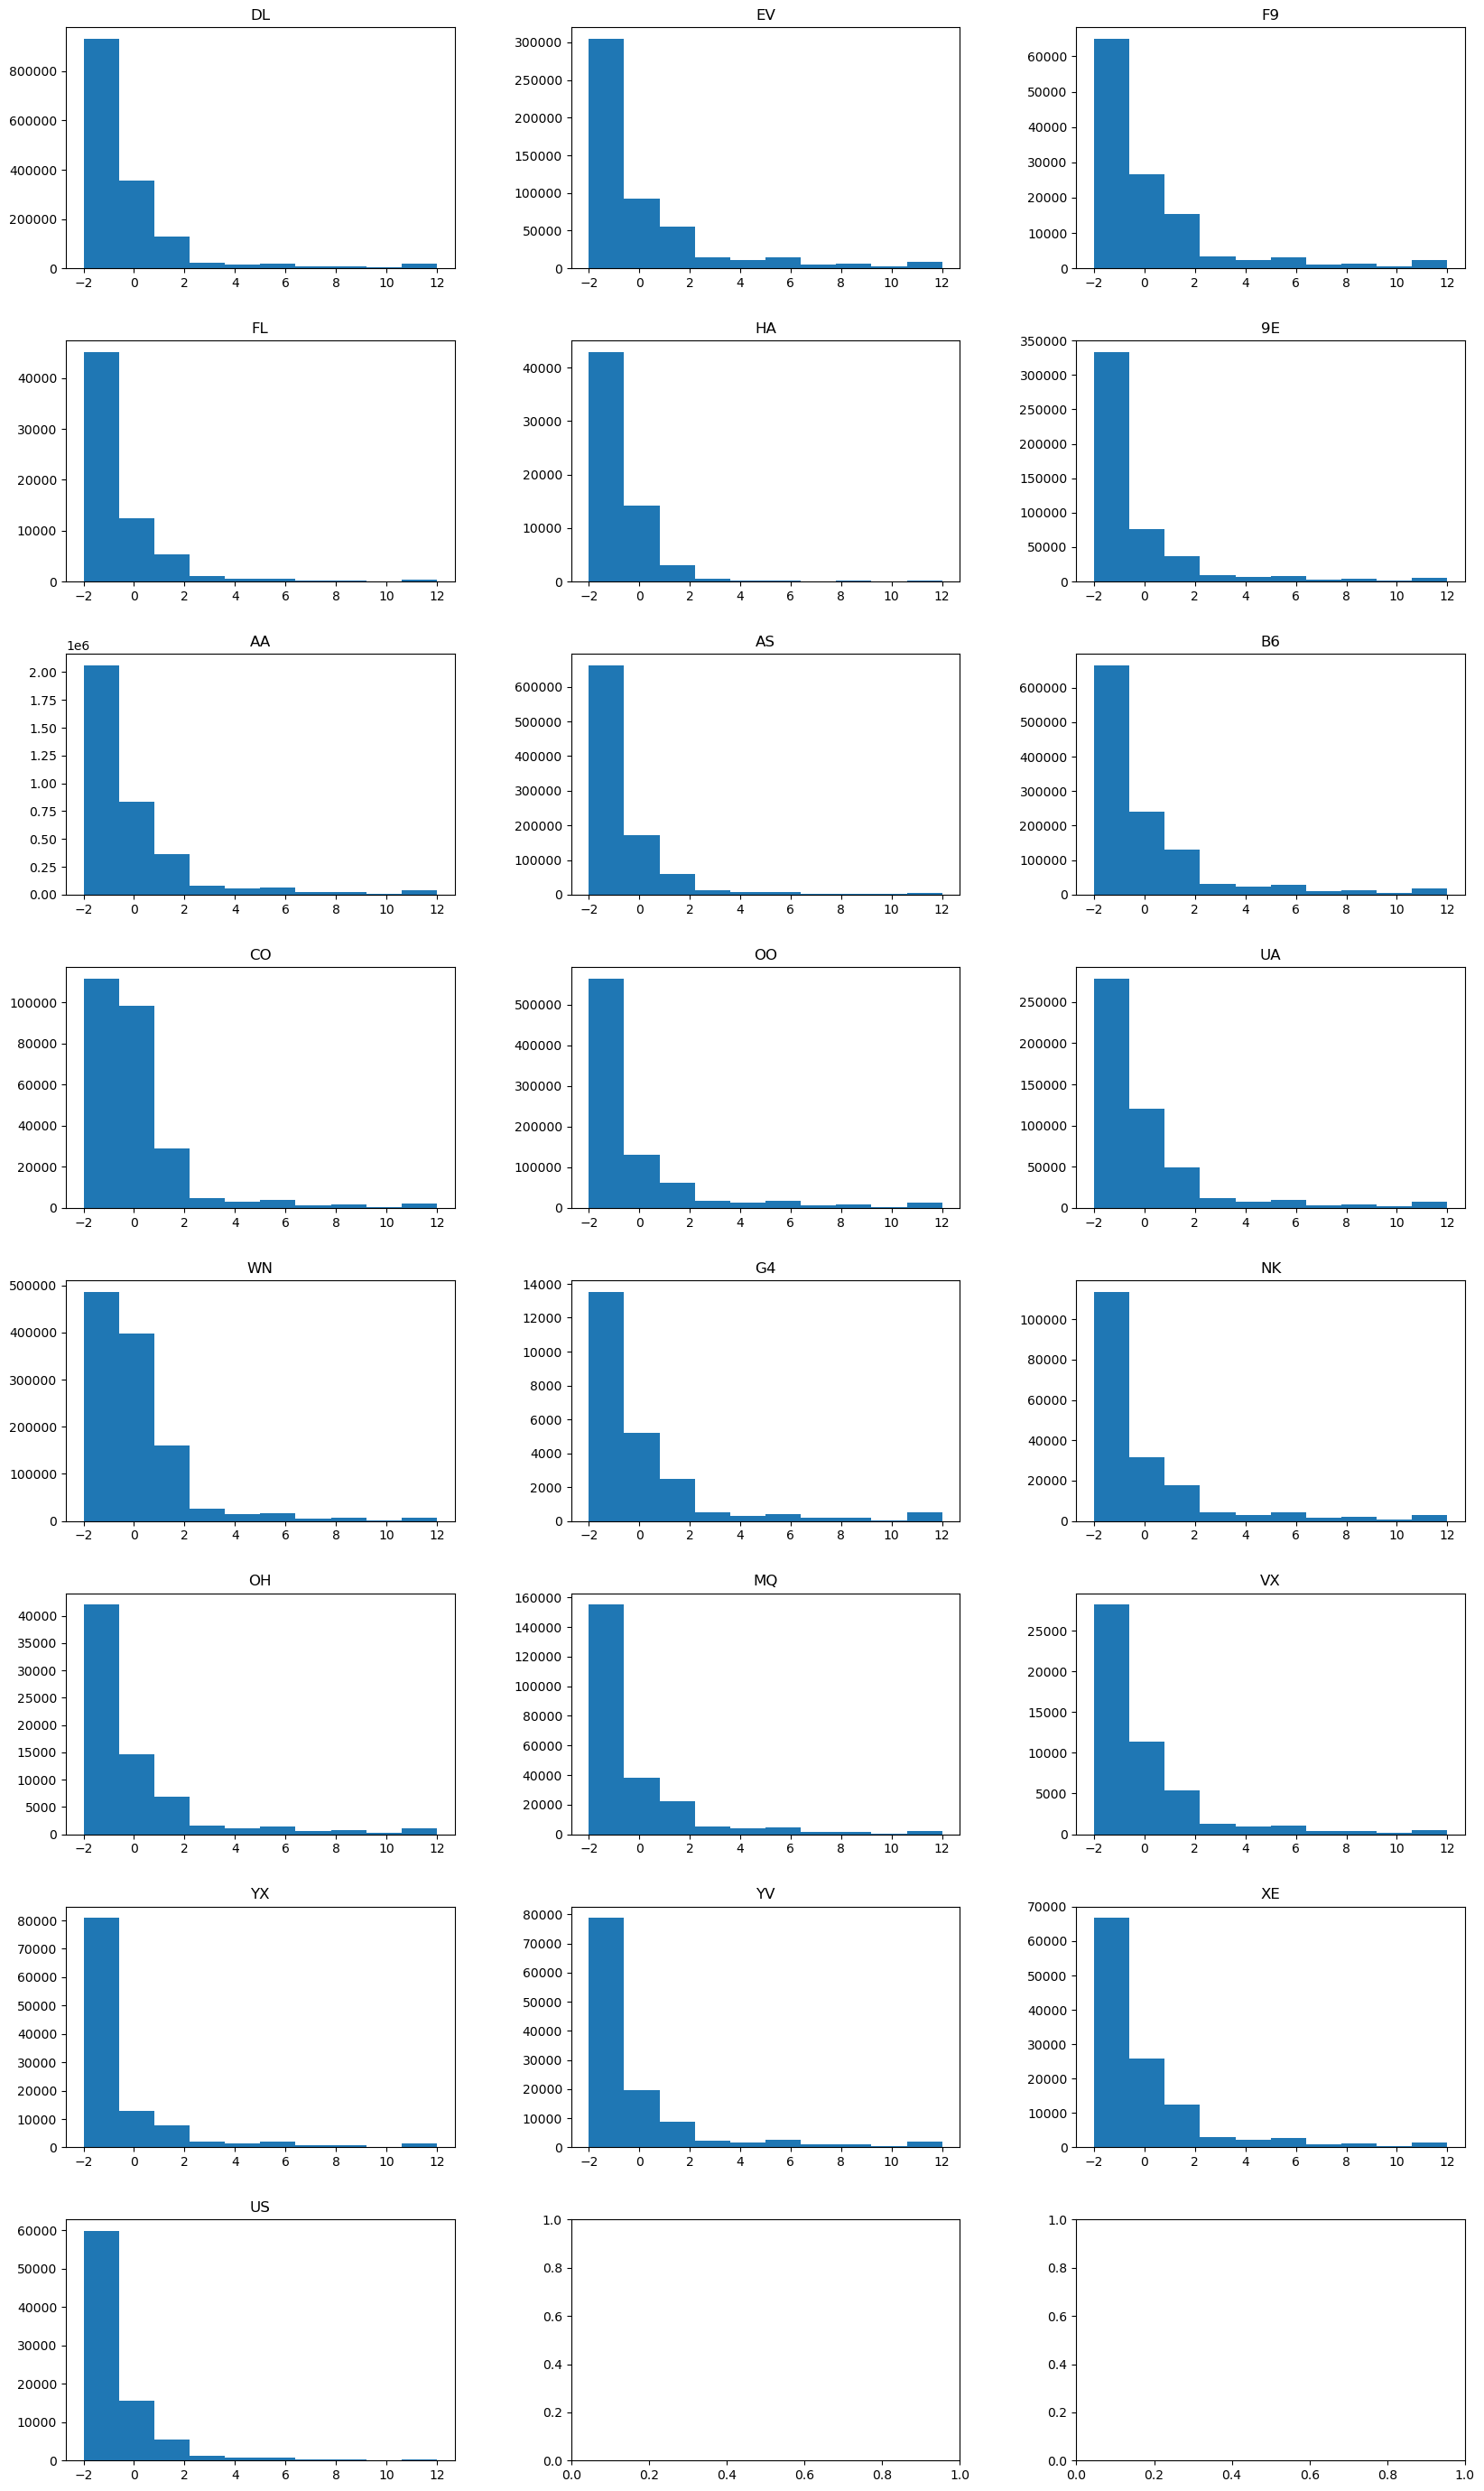

In [ ]:

fig,axes = plt.subplots(8,3, figsize=(20,35))
axes = axes.flatten()
for idx, al in enumerate(df.Reporting_Airline.unique()):
    df[df['Reporting_Airline']==al].hist(column='DepartureDelayGroups',
                                         grid=False,
                                         figsize=(15,20),
                                         ax=axes[idx])
    axes[idx].set_title(al)

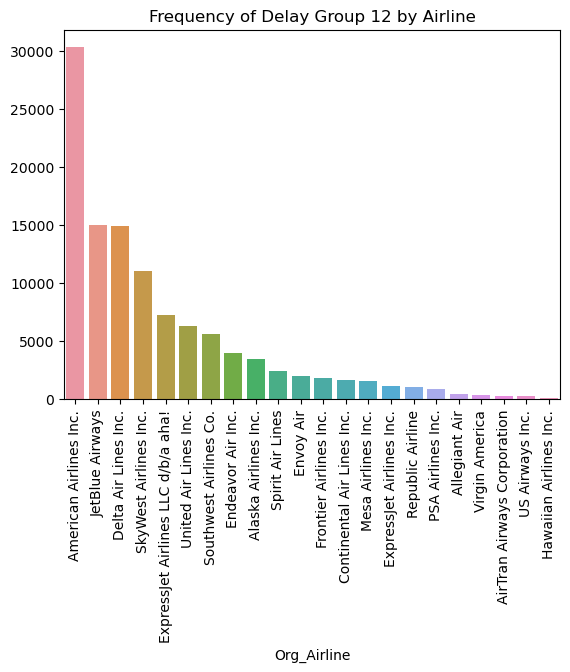

In [ ]:
max_dly_al = (df[df['DepartureDelayGroups']==12].groupby('Org_Airline')['FL_Num']
              .count()
              .sort_values(ascending=False))

sns.barplot(x=max_dly_al.index,
            y=max_dly_al.values)

plt.xticks(rotation = 90)
plt.title('Frequency of Delay Group 12 by Airline');

## Airports/States ##

In [ ]:
len(df.OriginAirportID.unique()), len(df.DestAirportID.unique())

(385, 385)

In [ ]:
airport = pd.read_csv('data/Airports.csv', index_col='Code')
airport.head()

,Description
Code,
10001,"Afognak Lake, AK: Afognak Lake Airport"
10003,"Granite Mountain, AK: Bear Creek Mining Strip"
10004,"Lik, AK: Lik Mining Camp"
10005,"Little Squaw, AK: Little Squaw Airport"
10006,"Kizhuyak, AK: Kizhuyak Bay"


In [ ]:
airport = airport['Description'].to_dict()

In [ ]:
# Get a df of aiports and the breakdowns of number that had departure delays vs didn't (include state so we can use it for addtl analysis)
ap_org_delay = pd.DataFrame(df.groupby(['OriginAirportID','OriginState', 'DepDel15'])['FL_Num'].count()).reset_index()
ap_org_delay['Airport'] = ap_org_delay['OriginAirportID'].map(airport)
ap_org_delay.head()

,OriginAirportID,OriginState,DepDel15,FL_Num,Airport
0,10135,PA,0.0,4166,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ..."
1,10135,PA,1.0,807,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ..."
2,10136,TX,0.0,1536,"Abilene, TX: Abilene Regional"
3,10136,TX,1.0,280,"Abilene, TX: Abilene Regional"
4,10140,NM,0.0,32337,"Albuquerque, NM: Albuquerque International Sun..."


In [ ]:
# For giggles, categorize each state into a region of the United States
region = {'NE': ['CT','ME','MA','NH','RI','VT','NJ','NY','PA'],
          'MW': ['IL','IN','MI','OH','WI','IA','KN','KS','MN','MO', 'NE','ND','SD'],
          'S': ['DE', 'FL','GA','MD', 'ND','NC','SC','VA', 'WV','AL','KY','MS','IN','AR', 'LA','OK','TX','TN'],
          'W': ['AZ','CA','CO','ID', 'MT','NV','NM','UT','WY','AK','HI','OR','WA'],
         'Othr': ['PR','TT','VI']}

def get_region(x):
    for key in region.keys():
        if x in region[key]:
            return key
    return None

ap_org_delay['Region'] = ap_org_delay['OriginState'].apply(get_region)

Text(0.5, 1.0, 'Total Number of Flights by State')

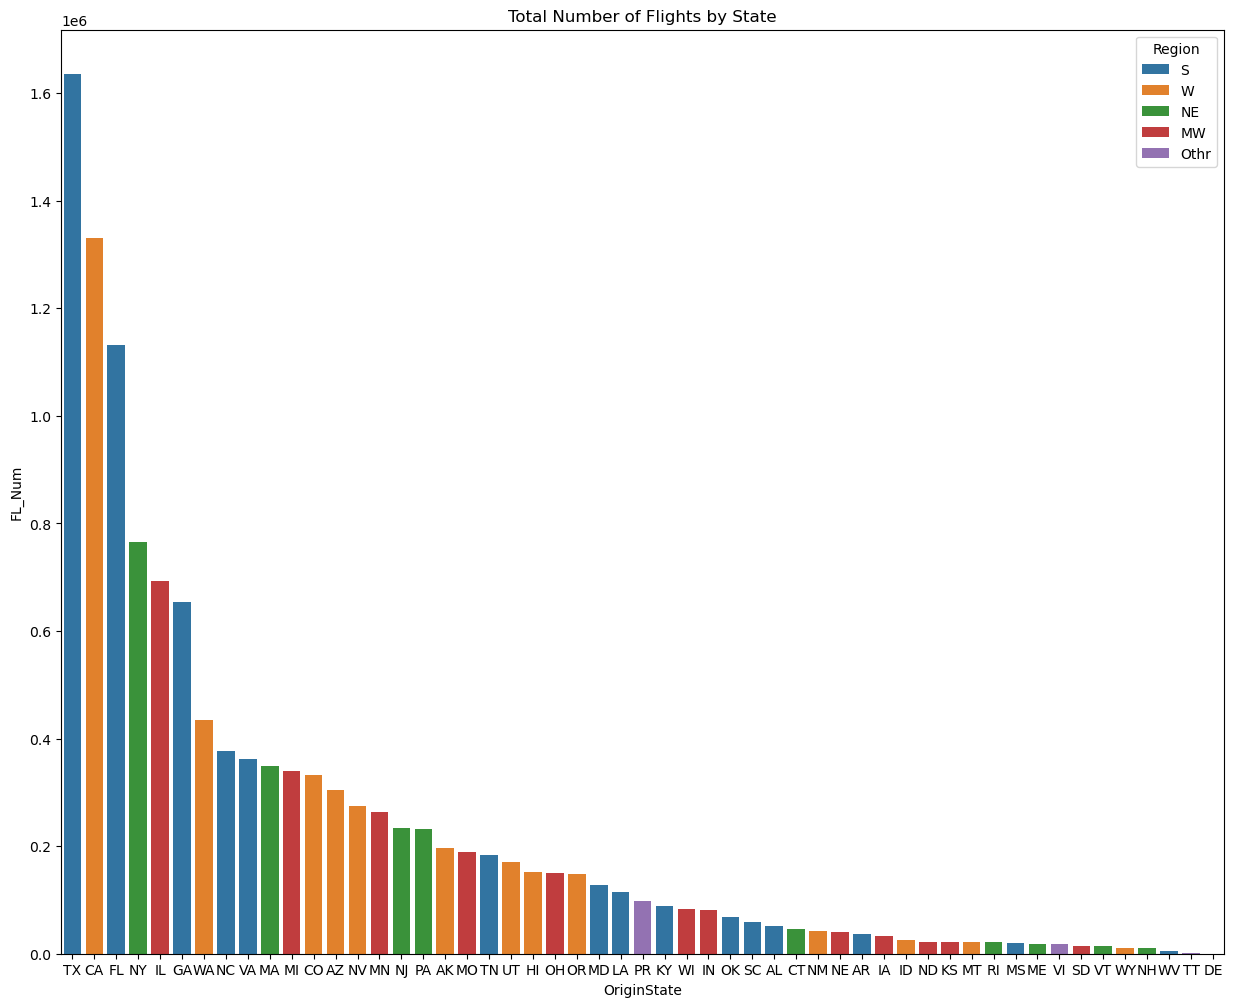

In [ ]:
# Use color encoding for Region
plt.figure(figsize=(15,12))
region_df = ap_org_delay.groupby(['OriginState','Region'])['FL_Num'].sum().sort_values(ascending=False).reset_index()
sns.barplot(data=region_df,
            x='OriginState',
            y='FL_Num',
            hue='Region',
            dodge=False)
plt.title('Total Number of Flights by State')

If you just focus on the top 10 States for Flights (in which we have delay data), 5 are in the South

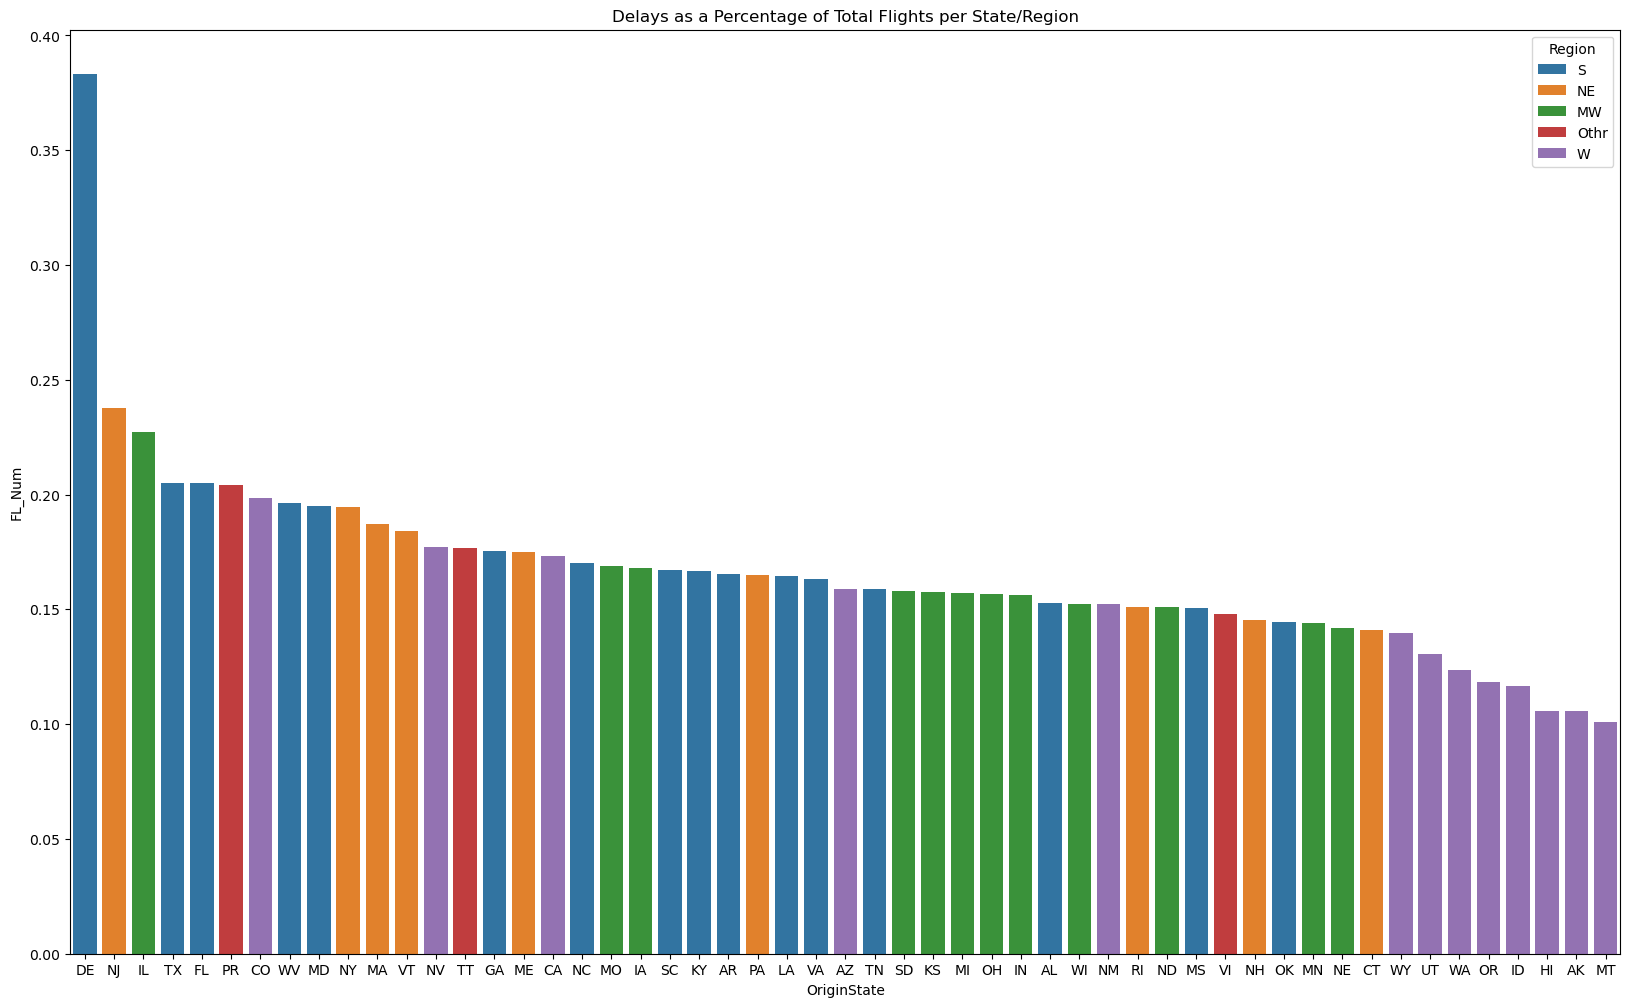

In [ ]:
state_dly = ap_org_delay[ap_org_delay['DepDel15']==1.0].groupby('OriginState')['FL_Num'].sum() / ap_org_delay.groupby('OriginState')['FL_Num'].sum()
state_dly.sort_values(ascending=False,inplace=True)
state_dly = state_dly.to_frame().reset_index()
state_dly['Region'] = state_dly['OriginState'].apply(get_region)



plt.figure(figsize=(20,12))
sns.barplot(
    data=state_dly,
    x='OriginState',
    y='FL_Num',
    hue='Region',
    dodge=False
)
plt.title('Delays as a Percentage of Total Flights per State/Region');


As a percentage, Delaware has the largest number of delays (but doesn't have a substantial proportion of total flights from prior chart).  Most Originating Northwestern State Flights have the lowest percentage of delayed flights.

<Axes: xlabel='Region'>

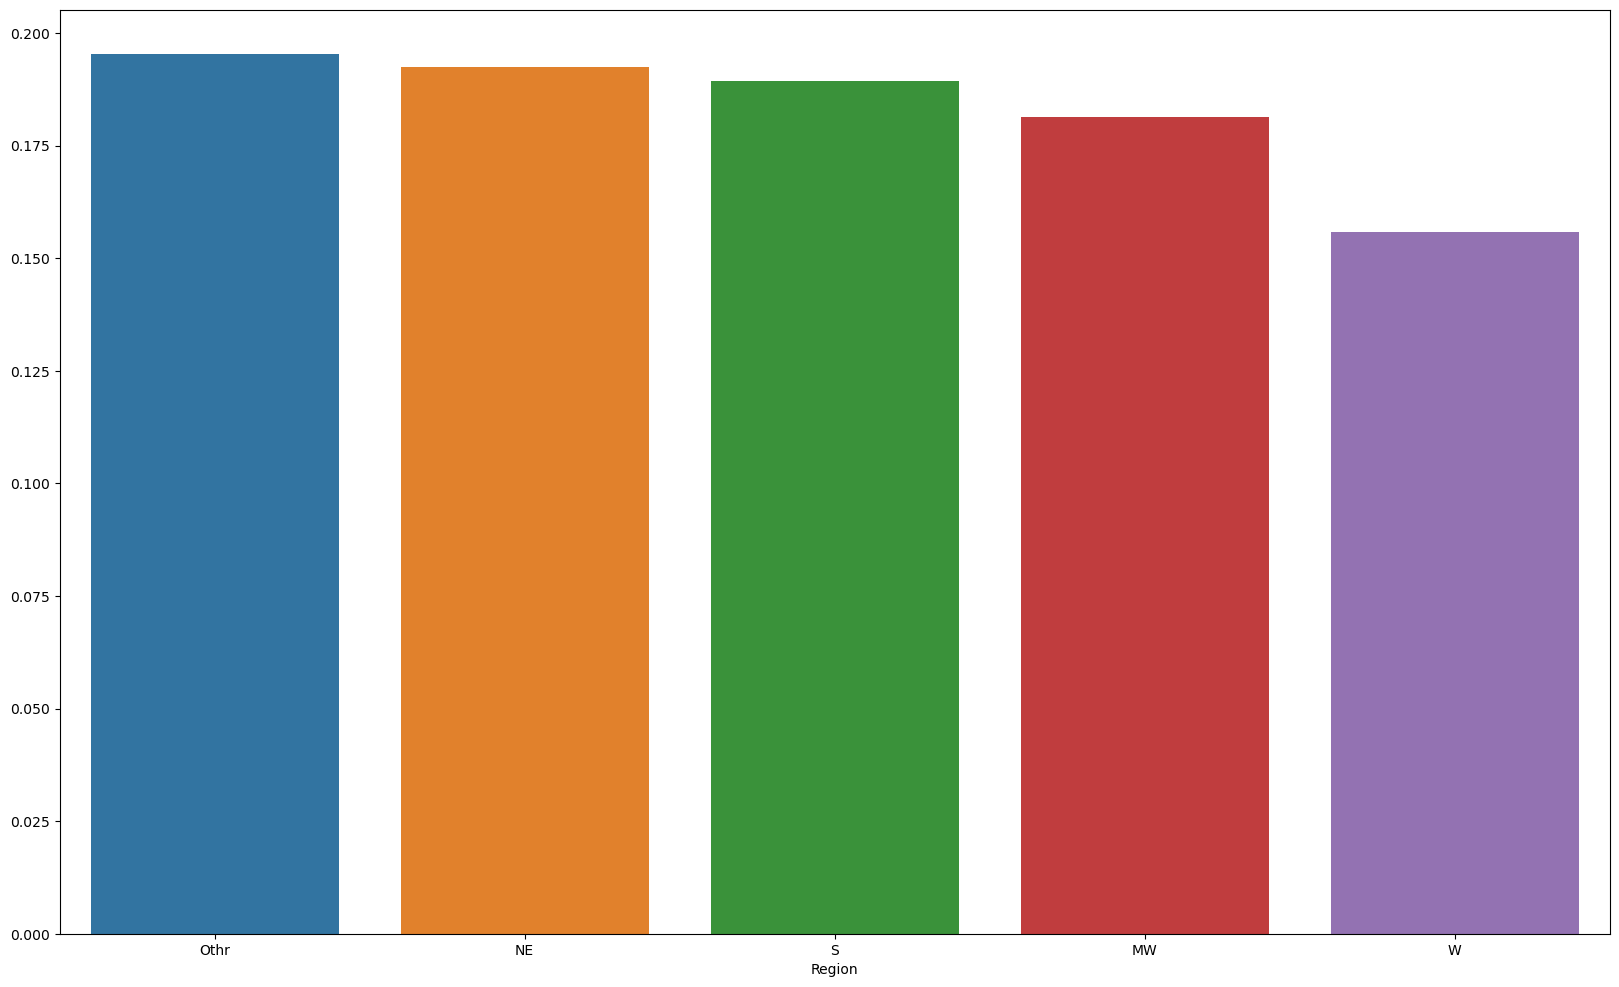

In [ ]:
region_dly = ap_org_delay[ap_org_delay['DepDel15']==1.0].groupby('Region')['FL_Num'].sum() / ap_org_delay.groupby('Region')['FL_Num'].sum()
region_dly.sort_values(ascending=False,inplace=True)

plt.figure(figsize=(20,12))
sns.barplot(
    x=region_dly.index,
    y=region_dly.values)

<Axes: xlabel='Region'>

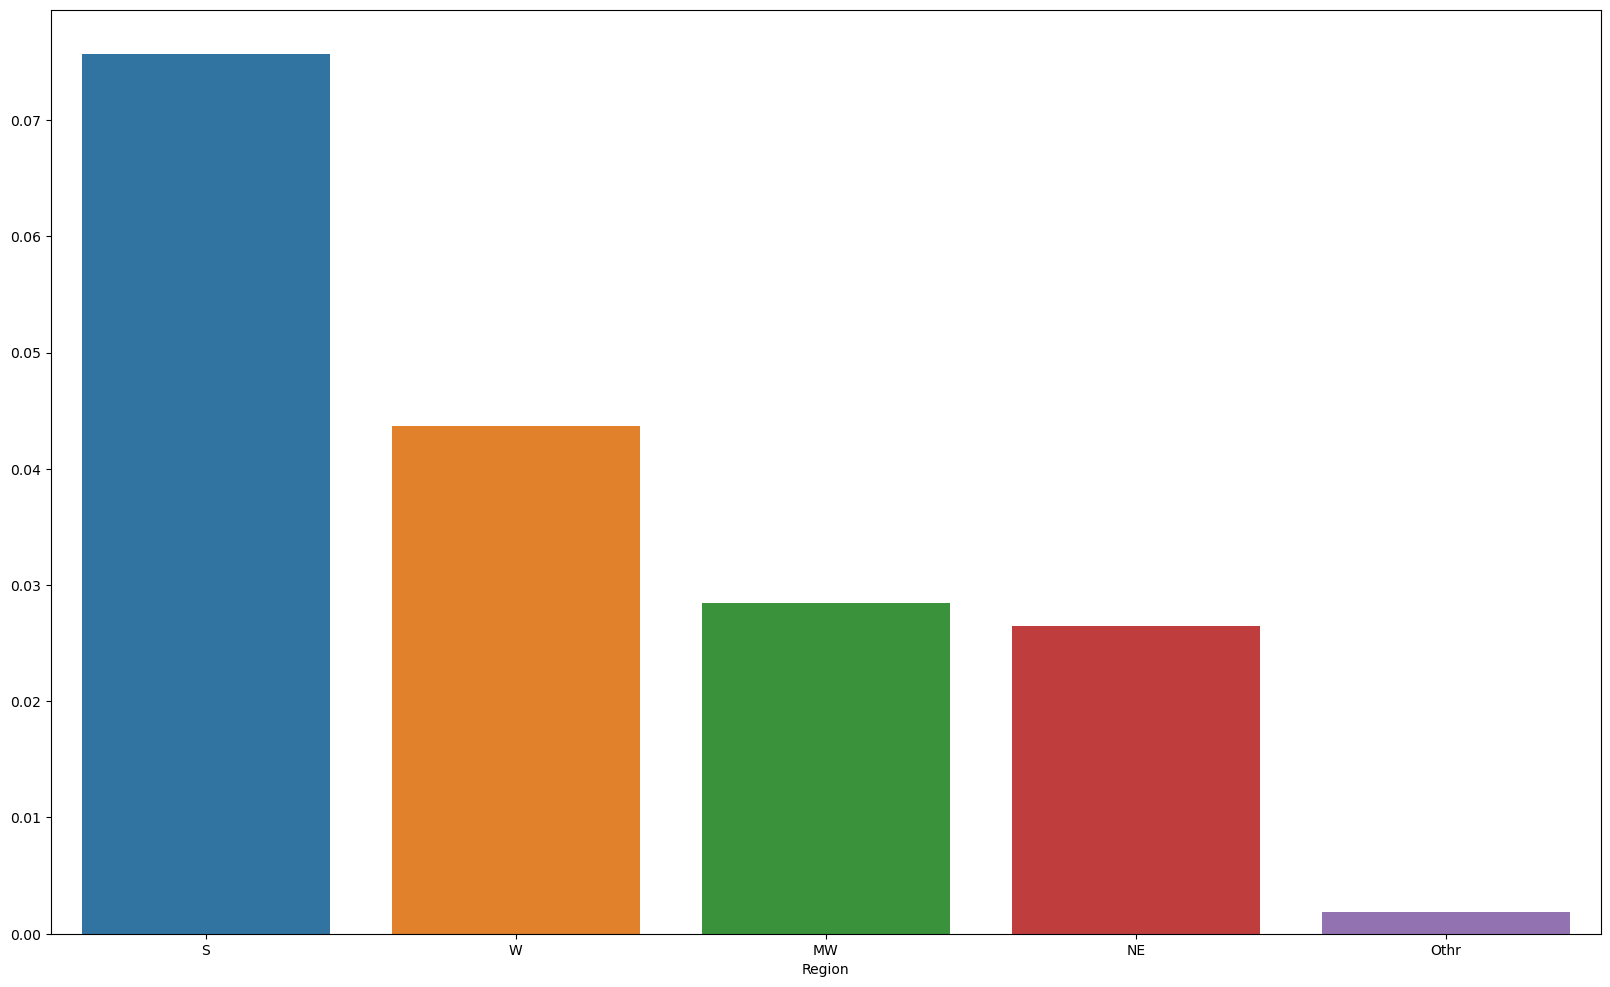

In [ ]:
region_prop_dly = ap_org_delay[ap_org_delay['DepDel15']==1.0].groupby('Region')['FL_Num'].sum() / len(df)
region_prop_dly.sort_values(ascending=False,inplace=True)

plt.figure(figsize=(20,12))
sns.barplot(
    x=region_prop_dly.index,
    y=region_prop_dly.values)

In [ ]:
ap_org_delay

,OriginAirportID,OriginState,DepDel15,FL_Num,Airport,Region
0,10135,PA,0.0,4166,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",NE
1,10135,PA,1.0,807,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",NE
2,10136,TX,0.0,1536,"Abilene, TX: Abilene Regional",S
3,10136,TX,1.0,280,"Abilene, TX: Abilene Regional",S
4,10140,NM,0.0,32337,"Albuquerque, NM: Albuquerque International Sun...",W
...,...,...,...,...,...,...
764,15991,AK,1.0,431,"Yakutat, AK: Yakutat Airport",W
765,16218,AZ,0.0,2470,"Yuma, AZ: Yuma MCAS/Yuma International",W
766,16218,AZ,1.0,251,"Yuma, AZ: Yuma MCAS/Yuma International",W
767,16869,ND,0.0,191,"Williston, ND: Williston Basin International",MW


In [ ]:

rte_df = df.groupby(['OriginAirportID','DestAirportID',])['FL_Num','DepDel15'].agg({'FL_Num': 'count','DepDel15':'sum'})
rte_df.reset_index(inplace=True)
rte_df['Origin'] = rte_df['OriginAirportID'].map(airport)
rte_df['Dest'] = rte_df['DestAirportID'].map(airport)

/var/folders/y2/s0rssrh12596xwpyfp42jb0h0000gn/T/ipykernel_26015/1252975223.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rte_df = df.groupby(['OriginAirportID','DestAirportID',])['FL_Num','DepDel15'].agg({'FL_Num': 'count','DepDel15':'sum'})


In [ ]:
rte_df['Delay%'] = rte_df['DepDel15'] / rte_df['FL_Num']
top100 = rte_df.sort_values('FL_Num', ascending=False)[:100]
top100.sort_values('Delay%',ascending=False)[:20]


,OriginAirportID,DestAirportID,FL_Num,DepDel15,Origin,Dest,Delay%
4154,13204,11618,16377,4761.0,"Orlando, FL: Orlando International","Newark, NJ: Newark Liberty International",0.290713
2076,11298,14771,21758,6205.0,"Dallas/Fort Worth, TX: Dallas/Fort Worth Inter...","San Francisco, CA: San Francisco International",0.285182
5283,13930,14771,16629,4662.0,"Chicago, IL: Chicago O'Hare International","San Francisco, CA: San Francisco International",0.280354
2579,11697,12478,17425,4876.0,"Fort Lauderdale, FL: Fort Lauderdale-Hollywood...","New York, NY: John F. Kennedy International",0.279828
2033,11298,13303,21126,5732.0,"Dallas/Fort Worth, TX: Dallas/Fort Worth Inter...","Miami, FL: Miami International",0.271324
4497,13303,12478,15628,4231.0,"Miami, FL: Miami International","New York, NY: John F. Kennedy International",0.270732
4508,13303,13930,18901,5030.0,"Miami, FL: Miami International","Chicago, IL: Chicago O'Hare International",0.266123
4499,13303,12892,16339,4152.0,"Miami, FL: Miami International","Los Angeles, CA: Los Angeles International",0.254116
3797,12892,14771,25095,6334.0,"Los Angeles, CA: Los Angeles International","San Francisco, CA: San Francisco International",0.252401
4171,13204,12478,22622,5659.0,"Orlando, FL: Orlando International","New York, NY: John F. Kennedy International",0.250155


In [ ]:
top100['Origin'] = top100['Origin'].apply(lambda x: x.split(':')[1])
top100['Dest'] = top100['Dest'].apply(lambda x: x.split(':')[1])
top100['Origin'] = top100['Origin'].str.strip()
top100['Dest'] = top100['Dest'].str.strip()

In [ ]:
top100['Route'] = top100['Origin'] + '-' + top100['Dest']
top100.sort_values('Delay%',ascending=False, inplace=True)

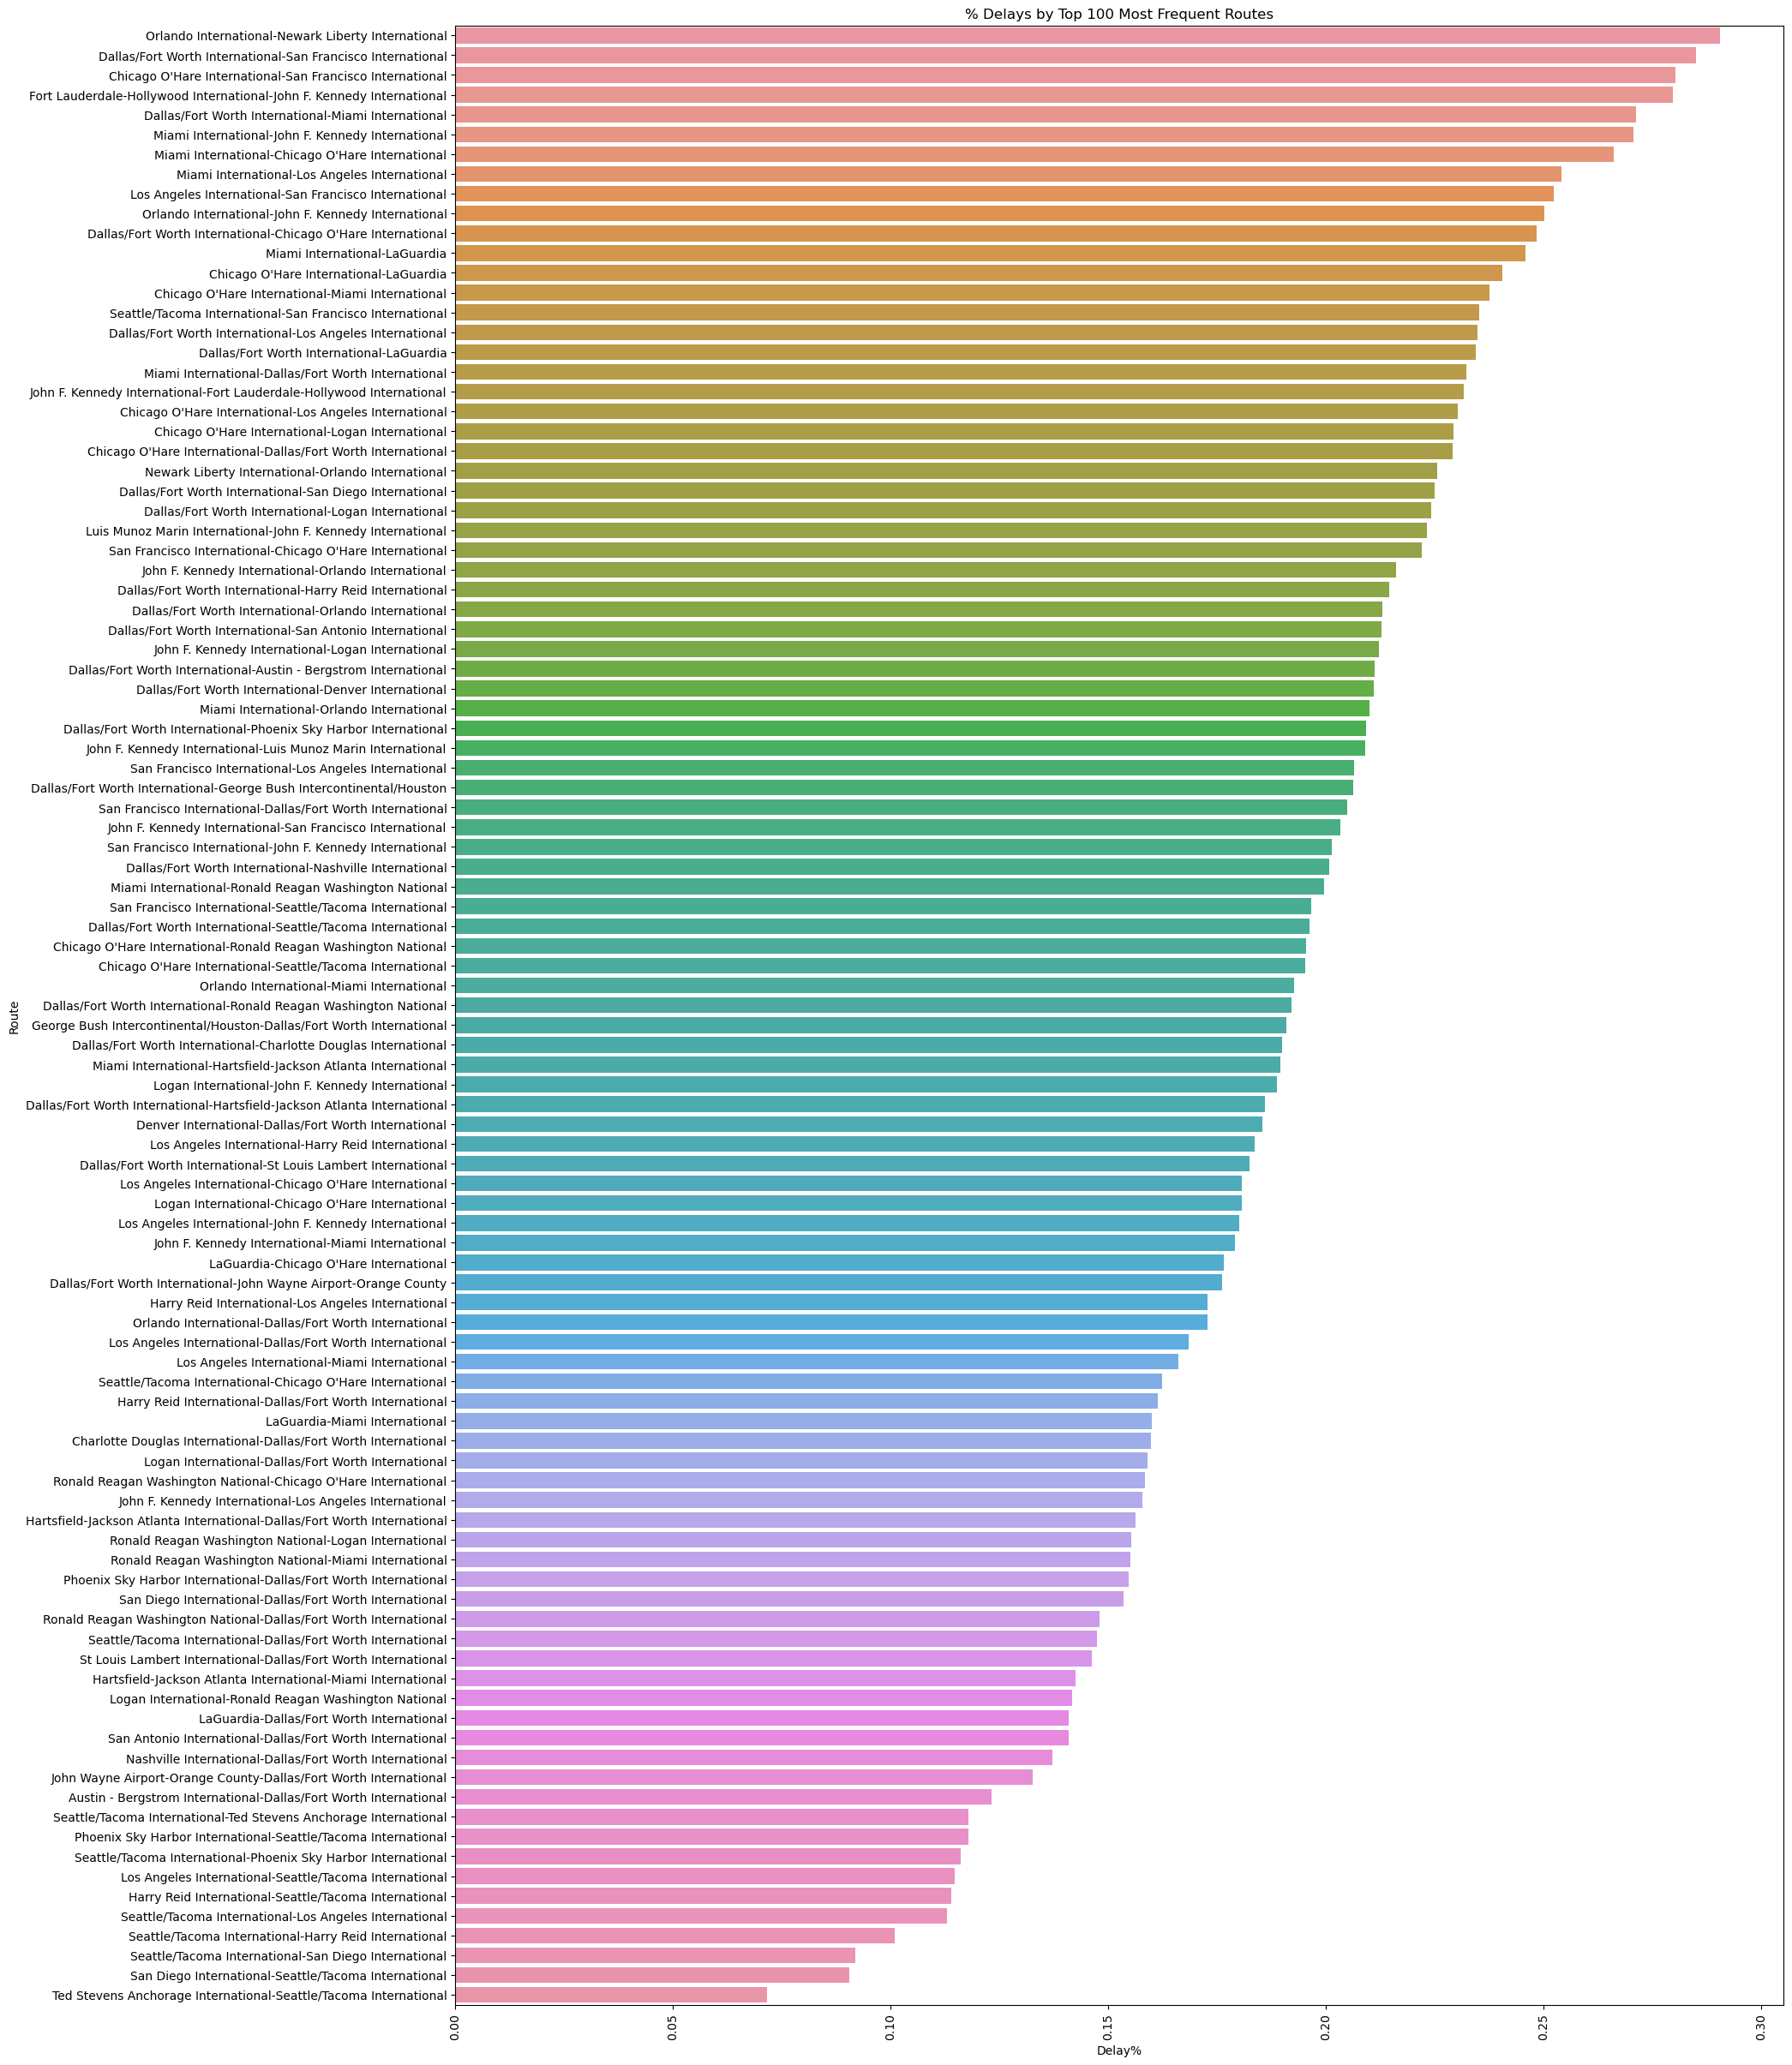

In [ ]:
plt.figure(figsize=(20,30))
sns.barplot(data=top100,
            y=f'Route',
            x='Delay%'
           )
plt.title('% Delays by Top 100 Most Frequent Routes')
plt.xticks(rotation = 90);

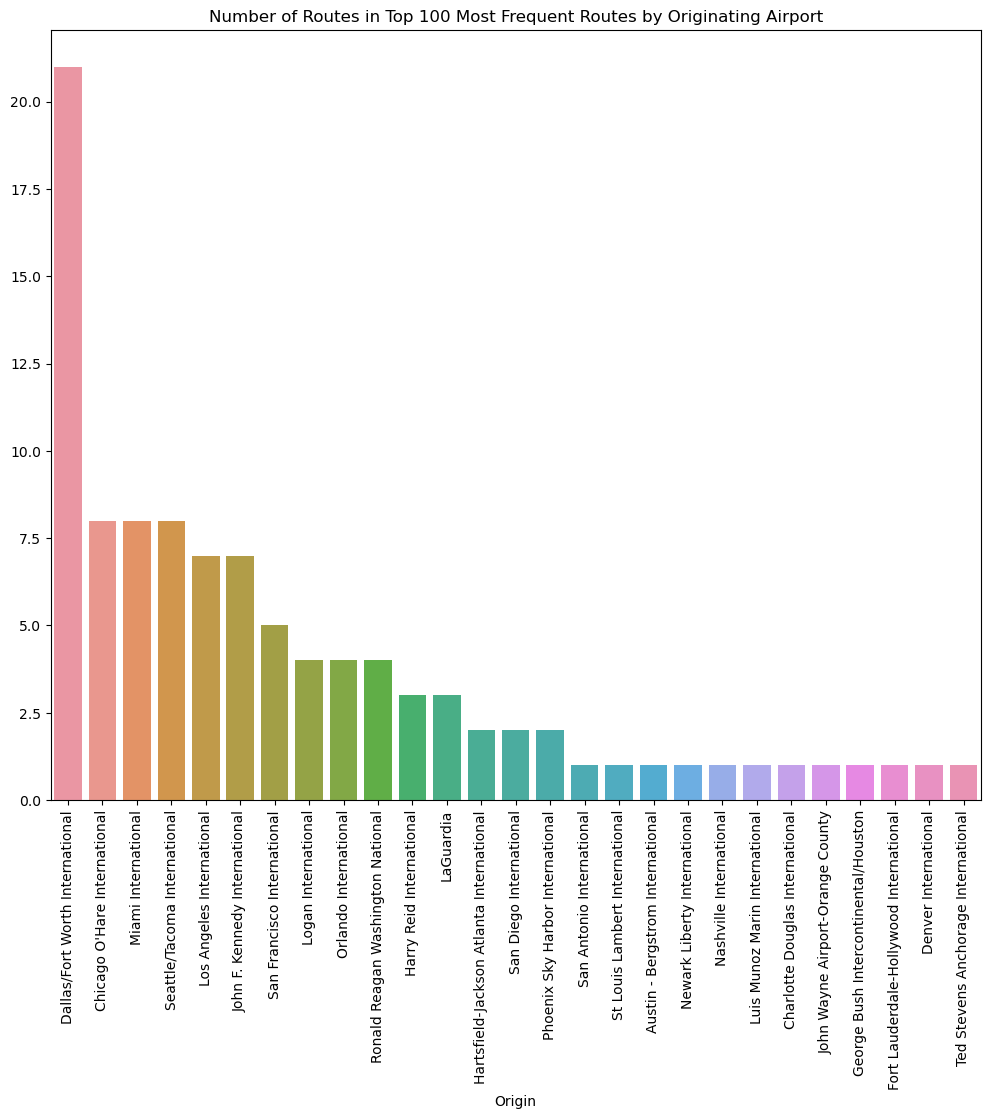

In [ ]:
plt.figure(figsize=(12,10))
routes = top100.groupby('Origin')['Dest'].count().sort_values(ascending=False)
sns.barplot(x=routes.index,
            y=routes.values)
plt.xticks(rotation = 90);
plt.title('Number of Routes in Top 100 Most Frequent Routes by Originating Airport');


Based on the flights for which we ahve delay information and are frequently traveled, we see a disproportionate number of flights leaving Dallas/FW Intl Airport.

In [ ]:
import altair as alt

In [ ]:
cht = alt.Chart(data=top100).mark_rect().encode(
 x='Origin:N',
 y='Dest:N',
 color='Delay%'
)

cht.properties(width=1000, height=1000, title='Top 100 Frequent Routes with % of Flights Delayed')

/Users/davidboudia/anaconda3/envs/python3_11/lib/python3.11/site-packages/altair/utils/core.py:283: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

Not surprisingly, We can see from the adjacency matrix above that Dallas/Ft Worth has a number of airports that it flies out to.  The Darker colors indicate higher percentage of delays for those destination flights.  In particular, flights to Miami, SF and Chi represent routes with the highest percentage of departure delays.

In [ ]:
hubs=pd.read_csv('data/Hubs.csv')

In [ ]:
hubs = hubs.iloc[:,:6]

In [ ]:
hubs= list(hubs['Code'])

In [ ]:
df['Hub'] = df['Origin'].apply(lambda x: 1 if x in hubs else 0)

In [ ]:
df.Hub.value_counts()

1    10668565
0     1631435
Name: Hub, dtype: int64

Over 10.5 million flights originated from Hubs, only 1.6 million were non-hub airports

In [ ]:
df.Hub.value_counts()

1    10668565
0     1631435
Name: Hub, dtype: int64

In [ ]:
df.groupby(['Hub','DepDel15'])['FL_Num'].count()

Hub  DepDel15
0    0.0         1352200
     1.0          243185
1    0.0         8584320
     1.0         1923562
Name: FL_Num, dtype: int64

In [ ]:
df.groupby(['Hub','DepDel15'])['FL_Num'].count() / df.groupby(['Hub'])['FL_Num'].count()

Hub  DepDel15
0    0.0         0.828841
     1.0         0.149062
1    0.0         0.804637
     1.0         0.180302
Name: FL_Num, dtype: float64

For Non-Hubs, a little over 15% of flights have departure delays; for Hubs over 18%

## Seasonality

1     1100000
3     1100000
2     1100000
10    1000000
6     1000000
5     1000000
4     1000000
8     1000000
9     1000000
7     1000000
12    1000000
11    1000000
Name: Month, dtype: int64


<Axes: >

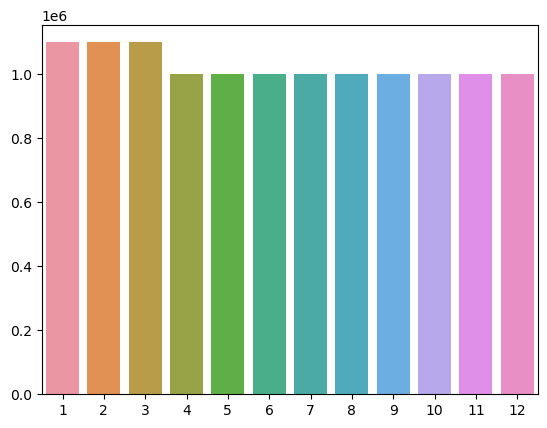

In [ ]:
mnths = df.Month.value_counts()
print(mnths)
sns.barplot(x=mnths.index,
            y=mnths.values)


# sns.barplot(data=df,
#              x='Month',
#              y='FL_Num')

# df.groupby('Month')['FL_Num'].count()

There doesn't seem to be a large increase in November/December where I would expect more holiday travel.  We see a jump in Q1 travel, however.

/var/folders/y2/s0rssrh12596xwpyfp42jb0h0000gn/T/ipykernel_26015/3650262650.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt='.2f', )


<Axes: >

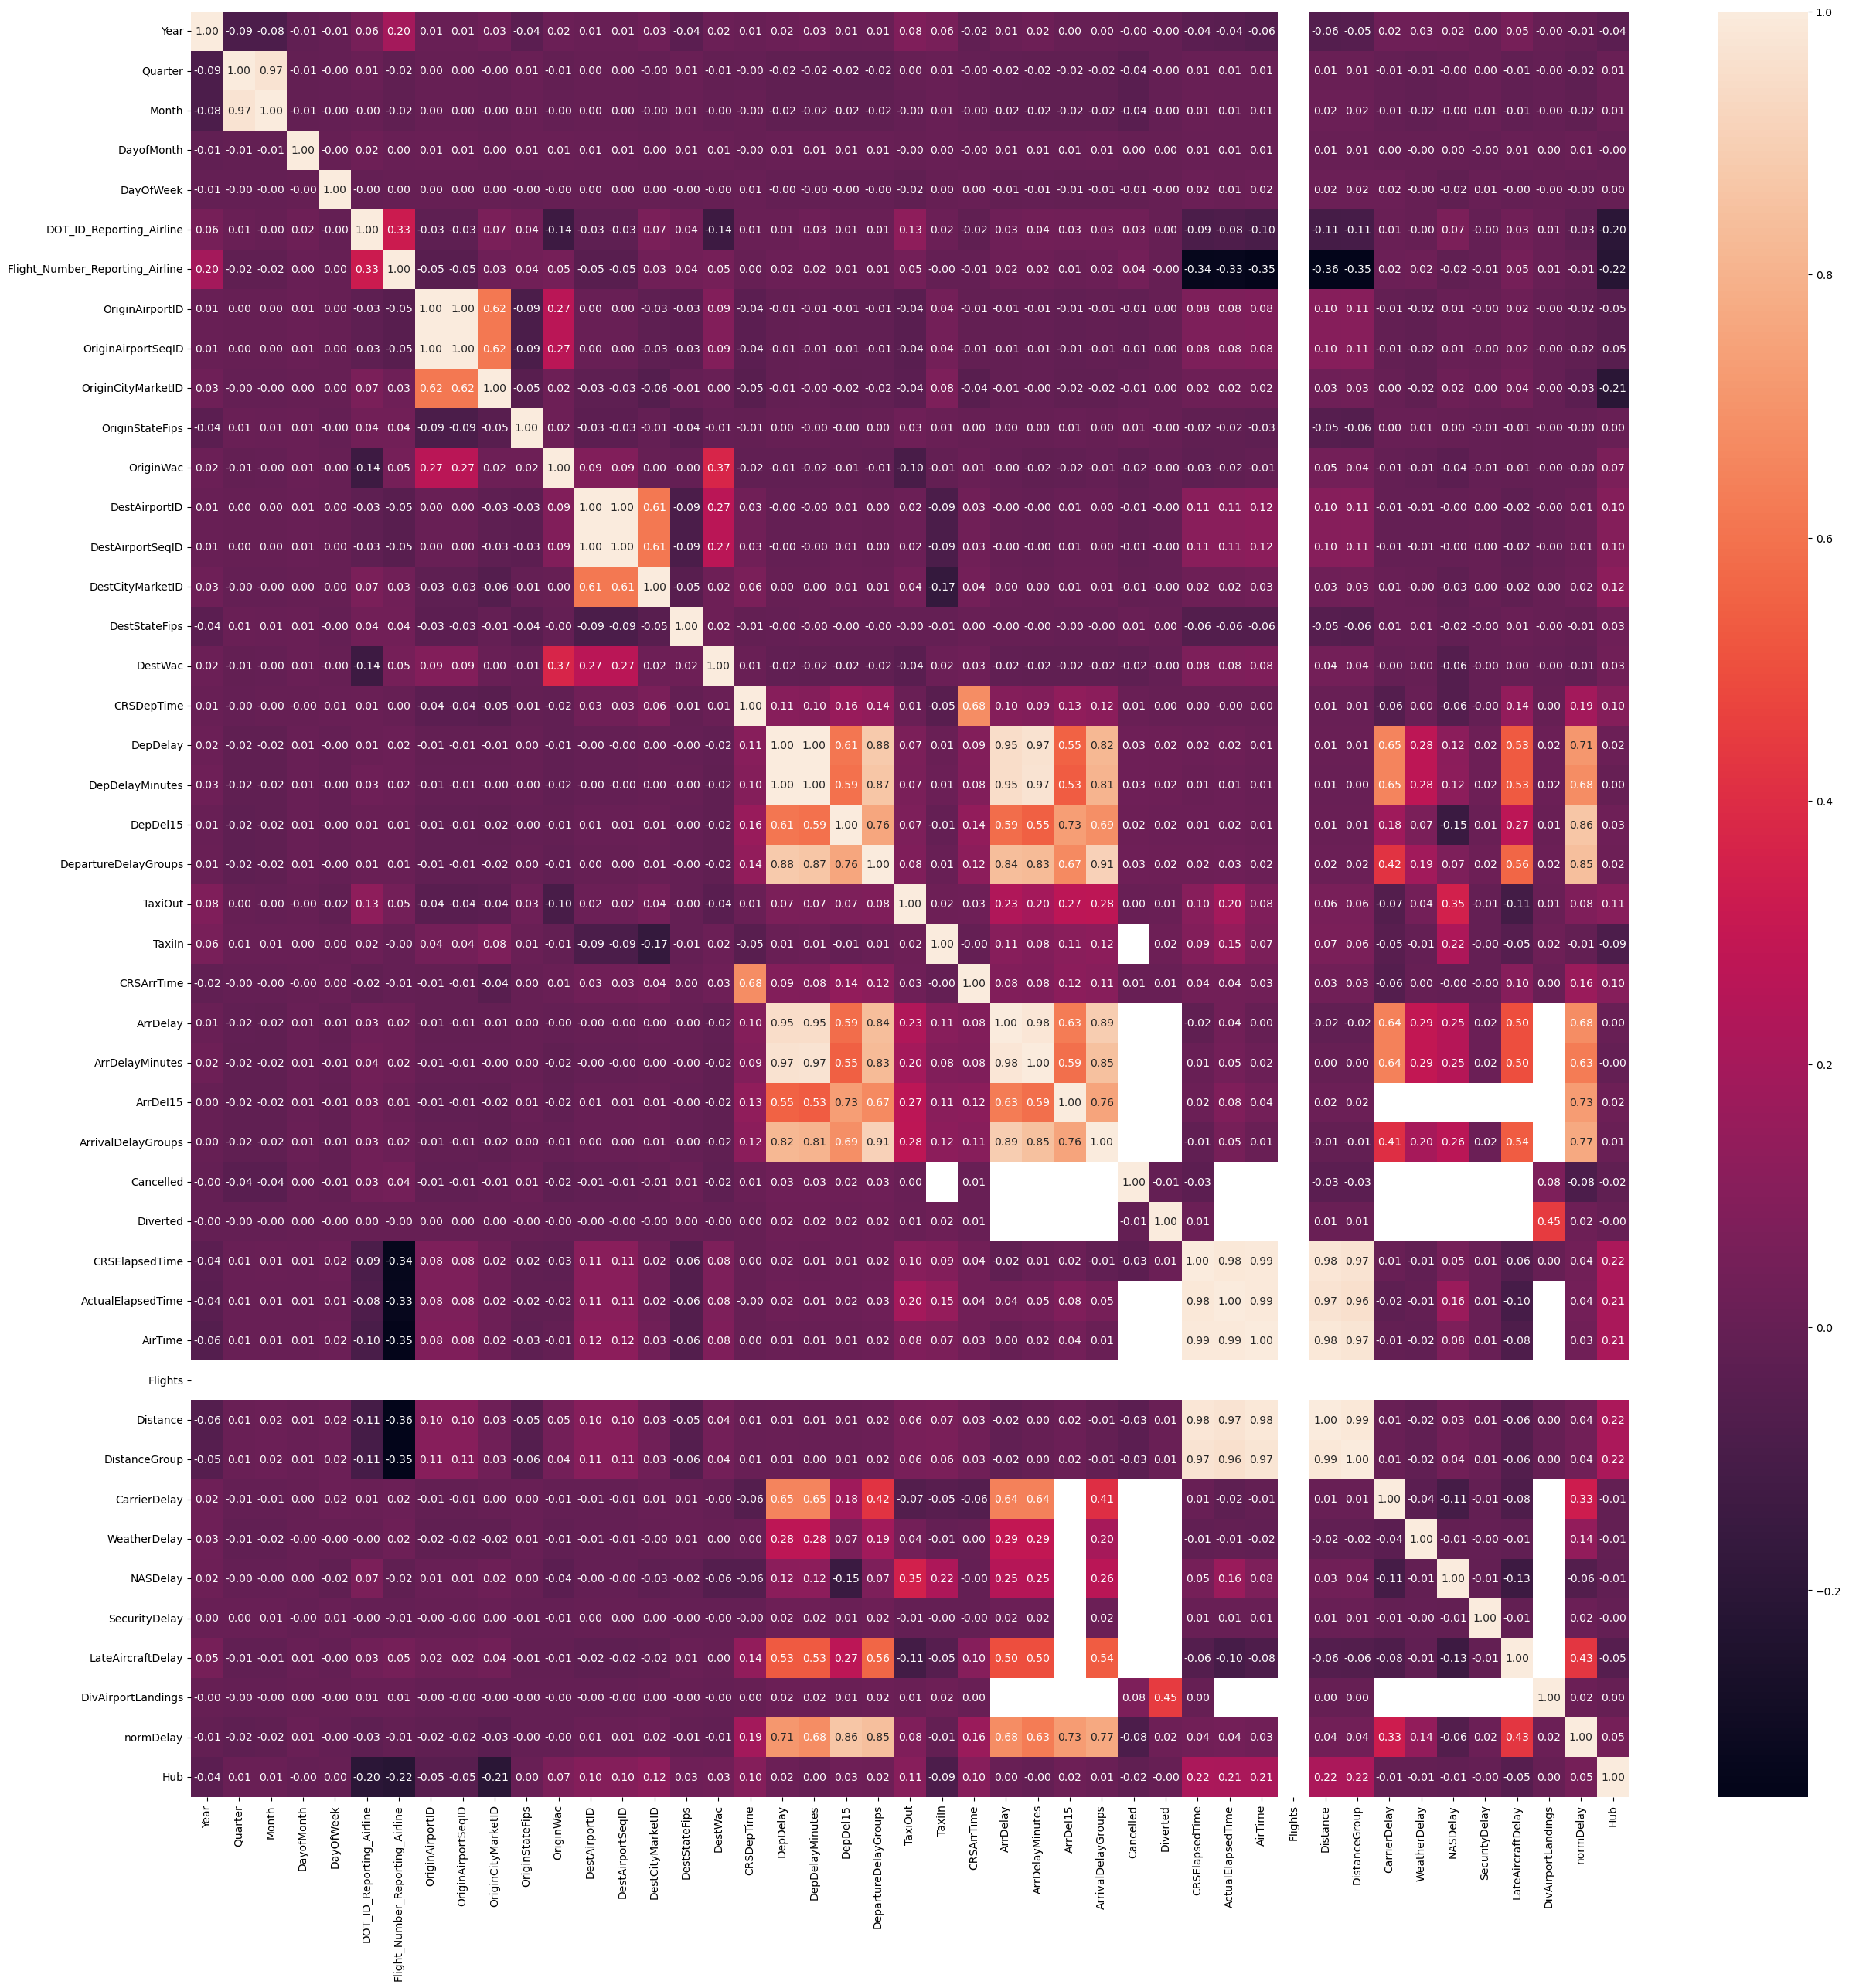

In [ ]:
plt.figure(figsize=(30,30))
sns.heatmap(df.corr(), annot=True, fmt='.2f', )

In [ ]:
aircraft = pd.read_csv('data/aircraft.csv')

In [ ]:
df_a = pd.merge(df,aircraft, how='left', left_on='Tail_Number', right_on='tail_no')

In [ ]:
df_a = df_a[df_a['mfr'].isna()==False]

In [ ]:
df_a_stats = df_a.groupby(['mfr'])['passengers','FL_Num'].agg({'FL_Num': 'count', 'passengers':'mean'}).sort_values(['passengers', 'FL_Num'],ascending=False)[['passengers','FL_Num']]
df_a_stats.rename({'FL_Num' : 'Num_Flights'}, axis=1,inplace=True)
df_a_stats

/var/folders/y2/s0rssrh12596xwpyfp42jb0h0000gn/T/ipykernel_26015/1579802027.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_a_stats = df_a.groupby(['mfr'])['passengers','FL_Num'].agg({'FL_Num': 'count', 'passengers':'mean'}).sort_values(['passengers', 'FL_Num'],ascending=False)[['passengers','FL_Num']]


,passengers,Num_Flights
mfr,,
AIRBUS,223.049747,1418681
AIRBUS INDUSTRIE,193.750023,788114
MCDONNELL DOUGLAS,166.059779,674272
BOEING,162.463071,3767340
MCDONNELL DOUGLAS AIRCRAFT CO,142.017892,297897
MCDONNELL DOUGLAS CORPORATION,142.000000,43200
DOUGLAS,102.000000,1122
EMBRAER S A,88.000000,269047
EMBRAER-EMPRESA BRASILEIRA DE,80.000000,34368


In [ ]:
df_a_stats.reset_index()
df_a_stats['perc_of_flights'] =  df_a_stats['Num_Flights'] / 10277101


In [ ]:
df_a_stats.head()

,passengers,Num_Flights,perc_of_flights
mfr,,,
AIRBUS,223.049747,1418681,0.138043
AIRBUS INDUSTRIE,193.750023,788114,0.076686
MCDONNELL DOUGLAS,166.059779,674272,0.065609
BOEING,162.463071,3767340,0.366576
MCDONNELL DOUGLAS AIRCRAFT CO,142.017892,297897,0.028986


In [ ]:
top_mfr = list(df_a_stats.head(13).index.values)

In [ ]:
df_a_stats.sort_values('perc_of_flights', ascending=False).head(30)

,passengers,Num_Flights,perc_of_flights
mfr,,,
BOEING,162.463071,3767340,0.366576
AIRBUS,223.049747,1418681,0.138043
BOMBARDIER INC,70.081812,1298831,0.126381
EMBRAER,39.456179,1101418,0.107172
AIRBUS INDUSTRIE,193.750023,788114,0.076686
MCDONNELL DOUGLAS,166.059779,674272,0.065609
MCDONNELL DOUGLAS AIRCRAFT CO,142.017892,297897,0.028986
EMBRAER S A,88.000000,269047,0.026179
CESSNA,6.255018,91489,0.008902


In [ ]:
aircraft.groupby('mfr')['passengers'].mean().sort_values(ascending=False).head(20)

mfr
AIRBUS                           246.978704
AIRBUS INDUSTRIE                 203.378319
BOEING                           196.659134
MCDONNELL DOUGLAS                161.565217
MCDONNELL DOUGLAS AIRCRAFT CO    142.125000
MCDONNELL DOUGLAS CORPORATION    142.000000
DOUGLAS                          102.000000
EMBRAER S A                       88.000000
EMBRAER-EMPRESA BRASILEIRA DE     80.000000
BOMBARDIER INC                    73.546092
CANADAIR                          55.000000
EMBRAER                           51.524618
DEHAVILLAND                       40.000000
SHORT BROS                        36.750000
GRUMMAN                           22.000000
GULFSTREAM AEROSPACE              21.500000
GULFSTREAM AEROSPACE LP           21.000000
DASSAULT                          21.000000
DASSAULT AVIATION                 16.400000
CANADAIR LTD                      15.333333
Name: passengers, dtype: float64

In [ ]:
air_mfr = pd.DataFrame(df_a[df_a['mfr'].isin(top_mfr)].groupby(['Reporting_Airline','mfr'])['FL_Num'].count()).reset_index()
air_mfr
# fig, ax = plt.subplots(11,2,figsize=(30,50))
# ax = ax.flatten()
# for idx, air in enumerate(air_mfr['Reporting_Airline'].unique()):
#     sns.barplot(data=air_mfr[air_mfr['Reporting_Airline']==air],
#                 x='Reporting_Airline',
#                 y='FL_Num',
#                 hue='mfr',
#                ax=ax[idx])



,Reporting_Airline,mfr,FL_Num
0,9E,BOMBARDIER INC,293271
1,AA,AIRBUS,265958
2,AA,AIRBUS INDUSTRIE,291214
3,AA,BOEING,328794
4,AA,BOMBARDIER INC,2244
5,AA,DEHAVILLAND,5946
6,AA,DOUGLAS,1002
7,AA,EMBRAER,43482
8,AA,MCDONNELL DOUGLAS,542133
9,AA,MCDONNELL DOUGLAS AIRCRAFT CO,410


In [ ]:
air_mfr.FL_Num.sum()

9724016

In [ ]:
list(air_mfr.Reporting_Airline.unique())

['9E',
 'AA',
 'AS',
 'B6',
 'CO',
 'DL',
 'EV',
 'F9',
 'FL',
 'HA',
 'MQ',
 'NK',
 'OH',
 'OO',
 'UA',
 'US',
 'VX',
 'WN',
 'XE',
 'YV',
 'YX']

In [ ]:
air_mfr

,Reporting_Airline,mfr,FL_Num
0,9E,BOMBARDIER INC,293271
1,AA,AIRBUS,265958
2,AA,AIRBUS INDUSTRIE,291214
3,AA,BOEING,328794
4,AA,BOMBARDIER INC,2244
5,AA,DEHAVILLAND,5946
6,AA,DOUGLAS,1002
7,AA,EMBRAER,43482
8,AA,MCDONNELL DOUGLAS,542133
9,AA,MCDONNELL DOUGLAS AIRCRAFT CO,410


In [ ]:
top_mfr

['AIRBUS',
 'AIRBUS INDUSTRIE',
 'MCDONNELL DOUGLAS',
 'BOEING',
 'MCDONNELL DOUGLAS AIRCRAFT CO',
 'MCDONNELL DOUGLAS CORPORATION',
 'DOUGLAS',
 'EMBRAER S A',
 'EMBRAER-EMPRESA BRASILEIRA DE',
 'BOMBARDIER INC',
 'CANADAIR',
 'DEHAVILLAND',
 'EMBRAER']

In [ ]:
aircraft.groupby(['mfr','model'])['tail_no'].count()

mfr                             model            
3D ROBOTICS                     SOLO                  1
4 SEASONS AVIATION              STARFLIGHT XC2000     1
AAI CORP DBA TEXTRON SYSTS UNM  AEROSONDE MK 47G      1
AERO COMMANDER                  1121                  1
                                500 S                 1
                                                     ..
YABORA INDUSTRIA AERONAUTICA S  ERJ 170-200 LL       20
                                ERJ 170-200 LR       36
YUNEEC INTERNATIONAL CO LTD     Q500 TYPHOON          1
ZING AEROSPORTS LLC             ZR-70                 1
ZITZMANN/LAWRENCE/GALEOTI       FALCON XP             1
Name: tail_no, Length: 536, dtype: int64

In [ ]:
aircraft.